# Bank Marketing Campaign

<b>Overview and Motivation:</b> The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit, variable y.

<b>Goal:</b> Goal is to identify the features/variables for a successful term deposit, which would save human effort and other resources involved in a direct marketing campaign.

<b>Approach:</b> - Classify customers capable of subscribing to the term deposit and optimize the target list of consumers of a campaign. Understand the factors that impact customer decisions.

<b>Data Source:</b>
UCI Machine Learning Repository to get the data.  https://archive.ics.uci.edu/ml/datasets/Bank+Marketing


In [45]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import requests, zipfile, StringIO
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import sklearn.svm
import csv

In [6]:
data=pd.read_csv('bank-additional-full.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


# Exploratory Data Analysis

In [10]:
# Exploring categorical data
col = data.columns.values
col = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
 'month', 'day_of_week','poutcome', 'y']

for id,val in enumerate(col,1):
    col_value = pd.unique(data[val].ravel())
    print "\n {}. Unique values for {} are \n {} \n Unique value total = {} ".format(id,val,col_value[:10],len(col_value))


 1. Unique values for job are 
 ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown'] 
 Unique value total = 12 

 2. Unique values for marital are 
 ['married' 'single' 'divorced' 'unknown'] 
 Unique value total = 4 

 3. Unique values for education are 
 ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 
 Unique value total = 8 

 4. Unique values for default are 
 ['no' 'unknown' 'yes'] 
 Unique value total = 3 

 5. Unique values for housing are 
 ['no' 'yes' 'unknown'] 
 Unique value total = 3 

 6. Unique values for loan are 
 ['no' 'yes' 'unknown'] 
 Unique value total = 3 

 7. Unique values for contact are 
 ['telephone' 'cellular'] 
 Unique value total = 2 

 8. Unique values for month are 
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 
 Unique value total = 10 

 9. Unique values for day_of_week are 
 ['mon' 'tue' 'wed' 'thu

In [14]:

data.groupby('y')#.mean() #pdays has negative impact, 49% of people have been contacted previously among 'yes'

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
yes,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [20]:
len(data[data.y=='yes'])*1.0/(len(data)) #11% have term deposit

0.11265417111780131

In [27]:
data[data.y=='yes'].corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.059319,-0.007920,-0.064991,0.074937,-0.081579,-0.024695,0.141166,-0.085403,-0.111972
duration,-0.059319,1.000000,0.156859,0.237858,-0.231527,0.503056,0.237558,-0.143827,0.499710,0.481981
campaign,-0.007920,0.156859,1.000000,0.106762,-0.104093,0.221760,0.116511,-0.042858,0.211863,0.202677
pdays,-0.064991,0.237858,0.106762,1.000000,-0.728953,0.280671,-0.055063,-0.169883,0.364535,0.453334
previous,0.074937,-0.231527,-0.104093,-0.728953,1.000000,-0.284754,0.091215,0.127833,-0.391993,-0.488325
emp.var.rate,-0.081579,0.503056,0.221760,0.280671,-0.284754,1.000000,0.660341,-0.267241,0.926117,0.787633
cons.price.idx,-0.024695,0.237558,0.116511,-0.055063,0.091215,0.660341,1.000000,-0.328344,0.414585,0.119655
cons.conf.idx,0.141166,-0.143827,-0.042858,-0.169883,0.127833,-0.267241,-0.328344,1.000000,-0.120171,-0.203270
euribor3m,-0.085403,0.499710,0.211863,0.364535,-0.391993,0.926117,0.414585,-0.120171,1.000000,0.922214
nr.employed,-0.111972,0.481981,0.202677,0.453334,-0.488325,0.787633,0.119655,-0.203270,0.922214,1.000000


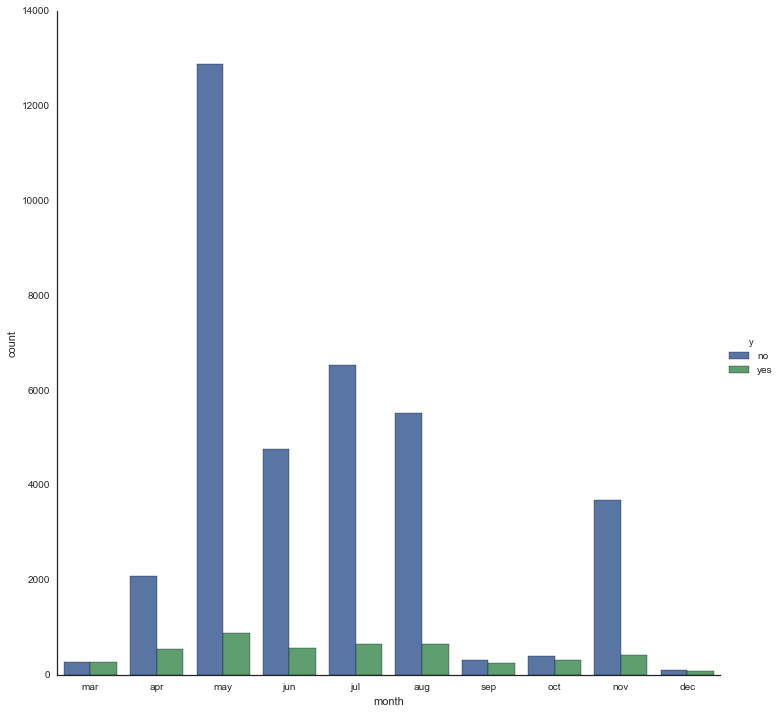

In [50]:
#histogram by month
mon = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
sns.factorplot("month",hue="y", data=data, kind="count",x_order=mon,size=10)


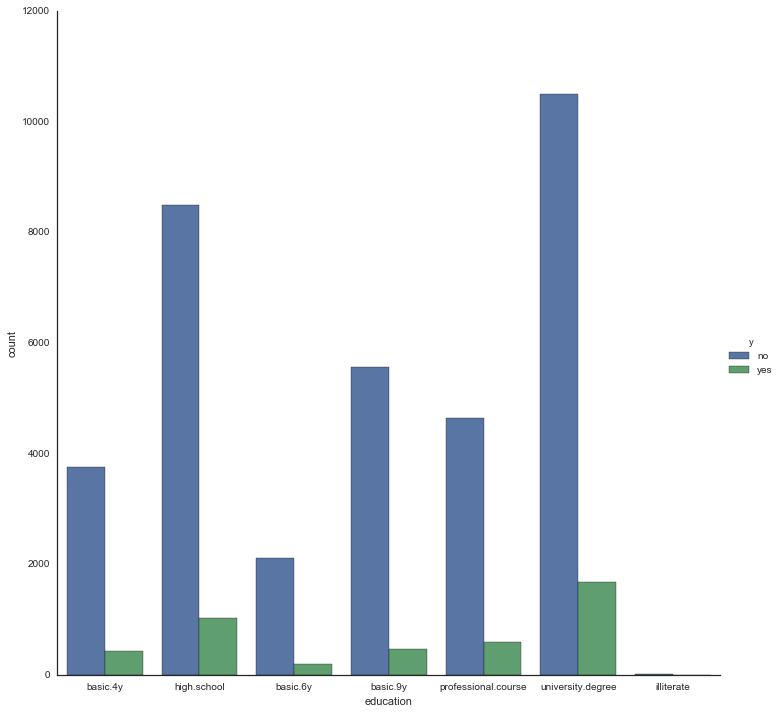

In [53]:
#histogram by education
g = sns.factorplot("education", hue="y", data=data[data['education']!='unknown'], kind='count', size=10)


AttributeError: 'tuple' object has no attribute 'show'

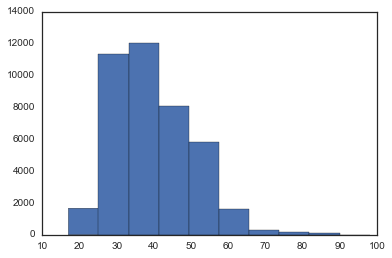

In [56]:
#histogram by age
plt.hist(data['age']).show()


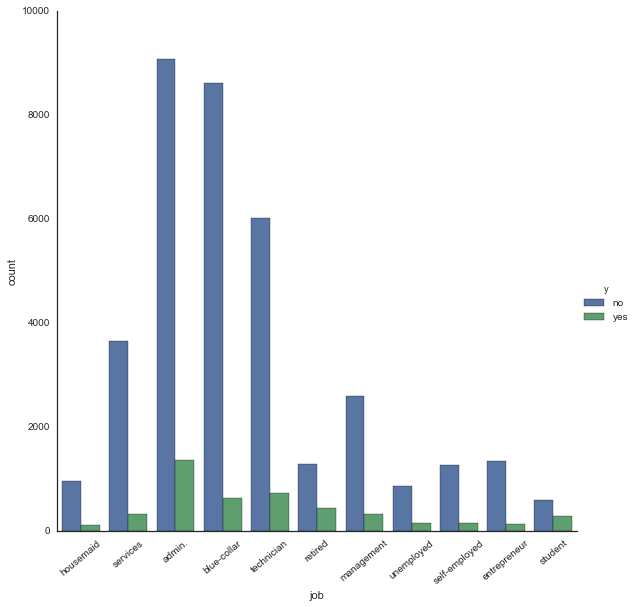

In [59]:
#histogram by job type
jobs = ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'retired',
 'management', 'unemployed', 'self-employed', 'entrepreneur',
 'student']
g = sns.factorplot("job", hue="y", data=data[data.job!='unknown'], kind='count', size=8, x_order=jobs)
g.set_xticklabels(rotation=40)

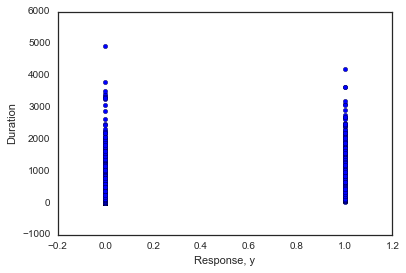

In [69]:
plt.scatter(data['y'].map({'yes':1,'no':0}),data[['duration']])
plt.ylabel("Duration")
plt.xlabel("Response, y")
plt.show()

# Preprocess

In [70]:
#One hot encoding for categorical data
vec = DictVectorizer()
dataproc = data
dataproc = dataproc[['age' ,'job' ,'marital', 'education', 'default' ,'housing', 'loan', 'contact',
 'month', 'day_of_week' , 'campaign', 'pdays', 'previous', 'poutcome',
 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx' ,'euribor3m' ,'nr.employed']]
d=dataproc.T.to_dict().values()
dataproc=vec.fit_transform(d).toarray()
yaxe=data['y'].map({'yes': 1, 'no': 0})

# Splitting the data into test data (30%) and training data (70%)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(dataproc, yaxe, test_size=0.30, random_state=1)

# Logistic Regression

In [164]:
logreg = linear_model.LogisticRegression(C=1e5)

logreg.fit(X_train, y_train)
LRprob = logreg.predict_proba(X_test)
LRpred = logreg.predict(X_test)
print metrics.accuracy_score(y_test, LRpred)
print metrics.roc_auc_score(y_test, LRpred)
LRprob[1,:]
#LR_predprobability[1,:]

0.896981467994
0.585595864994


array([ 0.96217659,  0.03782341])

## Predicting the Probability of a Term deposit for a specific customer

Let's predict the probability of customer accepting a term deposit for a customer not present in dataset.


In [79]:

# age-42,job=2,marital=1,education=6,default=0,housing=0,loan=0,contact=1,month=5,
# campaign=2,pdays=0,previous=0,poutcome=2,cons_price=93.994,cons_conf=-36.4,emp_var_rate=1.4,euribor3m=4.857,nr_emp=5191

logreg.predict_proba(np.array([
42,2,-36.4,93.994,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1.4,4.857,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,
0,0,5191,0,0,0,1,0]))

C:\Users\mahesh\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.73248445,  0.26751555]])

# Decision Tree

In [90]:
dtclf = DecisionTreeClassifier(random_state=1)
dtclf.fit(X_train, y_train)

scores_list = []
DTpred = dtclf.predict(X_test)
DTprob = dtclf.predict_proba(X_test)
print metrics.accuracy_score(y_test, DTpred)
print metrics.roc_auc_score(y_test, DTpred)
print dtclf.feature_importances_

0.840818969005
0.619837353801
[ 0.17072339  0.07635564  0.01824951  0.00897634  0.00240848  0.00571083
  0.01446518  0.01520089  0.01348527  0.01302089  0.01391909  0.00612924
  0.00850158  0.          0.00983911  0.00561006  0.01084649  0.01411821
  0.0003136   0.01147986  0.01859084  0.00606138  0.00251573  0.08729909
  0.02390873  0.00182289  0.02300002  0.02065117  0.01383988  0.00411993
  0.00463756  0.00865596  0.0054462   0.00602515  0.00865454  0.00271329
  0.01600436  0.00498207  0.00318975  0.01182518  0.00183735  0.01586867
  0.0110717   0.01542423  0.01864031  0.00050231  0.00299341  0.00174242
  0.          0.00360281  0.0006576   0.00096679  0.00134392  0.00106305
  0.00565854  0.00202472  0.15706216  0.04200044  0.00916218  0.00466322
  0.00089874  0.00951807]


In [122]:
df = pd.DataFrame({"Features": vec.get_feature_names(),"Importance": dtclf.feature_importances_})
df=df.sort_values(by='Importance', ascending = True)
df#.reset_index(inplace=True)


,Features,Importance
48,month=dec,0.000000
13,default=yes,0.000000
18,education=illiterate,0.000314
45,marital=unknown,0.000502
50,month=jun,0.000658
60,poutcome=success,0.000899
51,month=mar,0.000967
53,month=nov,0.001063
52,month=may,0.001344
47,month=aug,0.001742


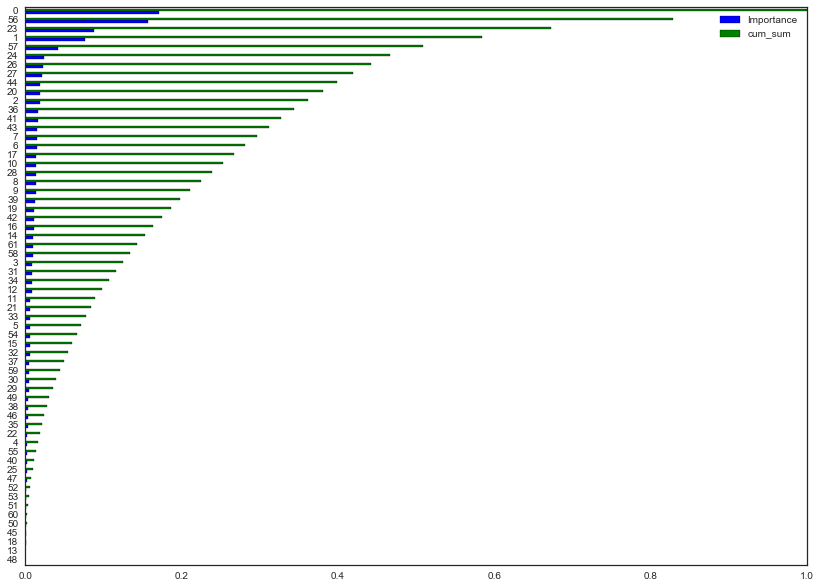

In [139]:
df['cum_sum'] = df.Importance.cumsum()
df.plot(kind='barh',align='center', figsize=(14,10))

# SVM

In [136]:
from time import time
clf_svm = sklearn.svm.SVC(class_weight='auto',probability=True)

t0 = time()
clf_svm.fit(X_train, y_train)
print "training time:", round(time()-t0, 3), "s"

t0 = time()
pred_svm = clf_svm.predict(X_test)
print "prediction time:", round(time()-t0, 3), "s"


print clf_svm.score(X_test,y_test)
print sklearn.metrics.roc_auc_score(y_test, pred_svm)
print sklearn.metrics.confusion_matrix(y_test, pred_svm)
print sklearn.metrics.classification_report(y_test, pred_svm)

training time: 692.846 s
prediction time: 17.859 s
0.847940438618
0.750823823425
[[9595 1349]
 [ 530  883]]
             precision    recall  f1-score   support

          0       0.95      0.88      0.91     10944
          1       0.40      0.62      0.48      1413

avg / total       0.88      0.85      0.86     12357



C:\Users\mahesh\Anaconda2\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


# Gaussian Naive Bayes Classifier

In [141]:
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB()
nbclf.fit(X_train, y_train)

nb_pred = nbclf.predict(X_test)
print metrics.accuracy_score(y_test, nb_pred)
print metrics.roc_auc_score(y_test, nb_pred)

0.853848021364
0.684204415298


In [145]:
svm_prob= clf_svm.predict_proba(X_test)
nb_prob=nbclf.predict_proba(X_test)

# K Nearest Neighbors

In [142]:
knnclf = KNeighborsClassifier()
knnclf.fit(X_train, y_train)

# predict class labels for the test set
knn_pred = knnclf.predict(X_test)
# generate class probabilities
knn_prob = knnclf.predict_proba(X_test)

# generate evaluation metrics
print metrics.accuracy_score(y_test, knn_pred)
print metrics.roc_auc_score(y_test, knn_pred)

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(knnclf, X_train, y_train, scoring='accuracy', cv=10)
print "CV scores :" , scores.mean()


0.889455369426
0.626956107759
CV scores : 0.890325988281


# Random Forest

In [144]:
rfclf = RandomForestClassifier(n_estimators=100,max_features='auto',min_samples_split=1)
rfclf.fit(X_train, y_train)
# predict class labels for the test set
rf_pred = rfclf.predict(X_test)
# generate class probabilities
rf_prob = rfclf.predict_proba(X_test)
# generate evaluation metrics
print metrics.accuracy_score(y_test, rf_pred)
print metrics.roc_auc_score(y_test, rf_pred)
print metrics.confusion_matrix(y_test, rf_pred)
print metrics.classification_report(y_test, rf_pred)

# evaluate the model using 10-fold cross-validation
scores = cross_val_score(rfclf, X_train, y_train, scoring='accuracy', cv=10)
print scores.mean()

0.891802217367
0.625507505494
[[10624   320]
 [ 1017   396]]
             precision    recall  f1-score   support

          0       0.91      0.97      0.94     10944
          1       0.55      0.28      0.37      1413

avg / total       0.87      0.89      0.88     12357

0.894072086438


# Evaluating Performance of Models <br> (Logistic Regression, Decision Trees, SVM, Gaussian NB, Random Forest)

## #1 ROC Curve

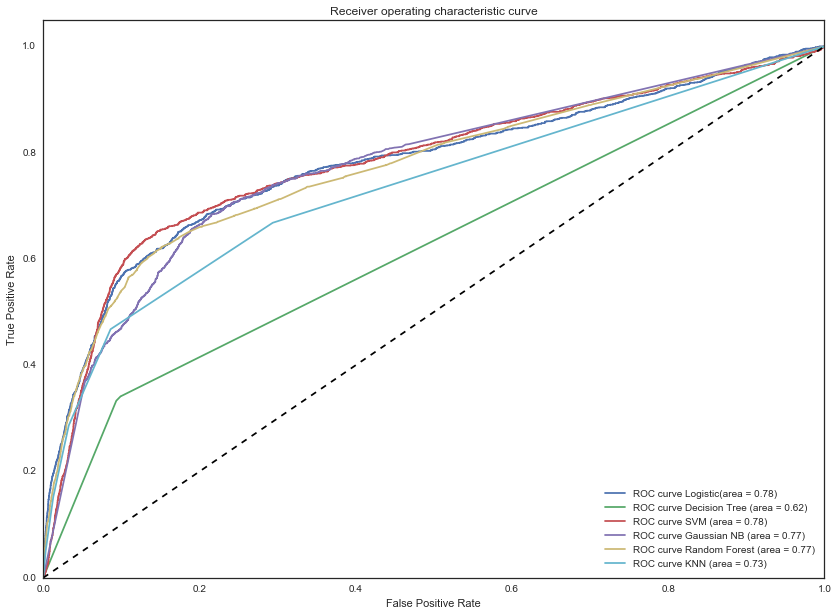

In [174]:
#Logistic Regression, Decision Trees, SVM, Gaussian NB, Random Forest
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_test, LRprob[:,1])
roc_auc[0] = auc(fpr[0], tpr[0])

fpr[1], tpr[1], _ = roc_curve(y_test, DTprob[:,1])
roc_auc[1] = auc(fpr[1], tpr[1])

fpr[2], tpr[2], _ = roc_curve(y_test, svm_prob[:,1])
roc_auc[2] = auc(fpr[2], tpr[2])

fpr[3], tpr[3], _ = roc_curve(y_test, nb_prob[:,1])
roc_auc[3] = auc(fpr[3], tpr[3])

fpr[4], tpr[4], _ = roc_curve(y_test, rf_prob[:,1])
roc_auc[4] = auc(fpr[4], tpr[4])

fpr[5], tpr[5], _ = roc_curve(y_test, knn_prob[:,1])
roc_auc[5] = auc(fpr[5], tpr[5])


# Plot of a ROC curve 
plt.figure(figsize=(14,10))
plt.plot(fpr[0], tpr[0], label='ROC curve Logistic(area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], label='ROC curve Decision Tree (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], label='ROC curve SVM (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], label='ROC curve Gaussian NB (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], label='ROC curve Random Forest (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5], label='ROC curve KNN (area = %0.2f)' % roc_auc[5])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

##  Lift Chart and Lift Curve 

Lift Chart/Lift Curve compares Predictive Models against Random results 

In [24]:
#This Function takes results of predict_proba(model), Y_test(Real result) and model name(for column names) as input
#This function calculates conversion_rate/Proportion of total sales for the the Nth percentile of predict_proba.
#it returns a data_frame with columns 'first n%', 'sales', 'sales_proportion' for first n%
def lift(prob, Y_t, model):
    final_prob_model = [i for i in prob[:,1]]
    prob_test_model = pd.DataFrame({ 'prob' : pd.Series(final_prob_model),
                           'result' : pd.Series(Y_t.ravel())
                        })
    lift_model = pd.DataFrame(columns=['first n%', 'sales_'+model, 'total_conversion_rate'])
    lift_model.loc[0] = [0,0,np.mean(prob_test_model['result'])]
    for p in np.arange(1,11,1):
        per = np.percentile(prob_test_model['prob'], 100-p*10)
        if (per==1):
            lift_model.loc[p] =  [p*10, np.sum(prob_test_model['result'][prob_test_model.prob >= per]), np.mean(prob_test_model['result'])]
        else:
            lift_model.loc[p] =  [p*10, np.sum(prob_test_model['result'][prob_test_model.prob > per]), np.mean(prob_test_model['result'])]
    #lift_model['lift_'+model] = lift_model['conversion_rate_'+model]/lift_model['total_conversion_rate_'+model]
    lift_model['sales_proportion_'+model] = lift_model['sales_'+model]/np.sum(prob_test_model['result'])*100
    return lift_model

In [25]:
lift_LR = lift(LR_predprobability, Y_test, 'LR')
lift_DT = lift(DT_predprobability, Y_test, 'DT')
lift_NB = lift(NB_predprobability, Y_test, 'NB')
lift_SVM = lift(SVM_predprobability, Y_test, 'SVM')
lift_KNN = lift(KNN_predprobability, Y_test, 'KNN')
lift_RF = lift(RF_predprobability, Y_test, 'RF')

lift_comp = lift_LR[['first n%', 'total_conversion_rate', 'sales_proportion_LR']]

lift_comp['sales_proportion_DT'] = lift_DT['sales_proportion_DT']
lift_comp['sales_proportion_NB'] = lift_NB['sales_proportion_NB']
lift_comp['sales_proportion_SVM'] = lift_SVM['sales_proportion_SVM']
lift_comp['sales_proportion_KNN'] = lift_KNN['sales_proportion_KNN']
lift_comp['sales_proportion_RF'] = lift_RF['sales_proportion_RF']

lift_comp

,first n%,total_conversion_rate,sales_proportion_LR,sales_proportion_DT,sales_proportion_NB,sales_proportion_SVM,sales_proportion_KNN,sales_proportion_RF
0,0,0.1124059,0,0,0,0,0,0
1,10,0.1124059,41.61267,34.70122,41.2527,40.60475,27.86177,33.18934
2,20,0.1124059,61.48308,35.63715,57.4514,62.63499,46.00432,49.964
3,30,0.1124059,69.90641,35.63715,68.61051,69.76242,46.00432,59.75522
4,40,0.1124059,75.08999,35.63715,74.37005,75.59395,66.59467,59.75522
5,50,0.1124059,80.56156,35.63715,79.91361,79.19366,66.59467,73.29014
6,60,0.1124059,85.74514,35.63715,84.59323,84.30526,66.59467,73.29014
7,70,0.1124059,89.84881,35.63715,89.05688,88.40893,66.59467,73.29014
8,80,0.1124059,93.59251,35.63715,92.08063,91.64867,66.59467,73.29014
9,90,0.1124059,96.97624,35.63715,96.32829,95.96832,66.59467,73.29014


### Comparing different models based on Lift Chart 

###### Observation 13

Sales_proportion - It tells total number of true conversions in the first n% of high probabilites in predict_proba

                   for example sales_proportion_SVM is 40.6 for first 10%. 
                   
If clients are contacted randomly without using any predictors 10% of leads would yield to 10% of total sales, 20% of leads would yield to 20% of total sales and so on. But if we use a predictor and choose clients according to the rank of probabilities, there will be a lift in converstion rate. In the above example first 10% of the leads would lead to 40.6% of the total sales, which is a very useful information for the Bank



<b>SVM, Logistic Regression and Gaussian Naive Bayes have better performance when compared to Random Forests, KNN and Decision.
Trees. </b>

****************************************************************************************

## Lift Curve

The same data in Lift chart is visualised in Lift Curve

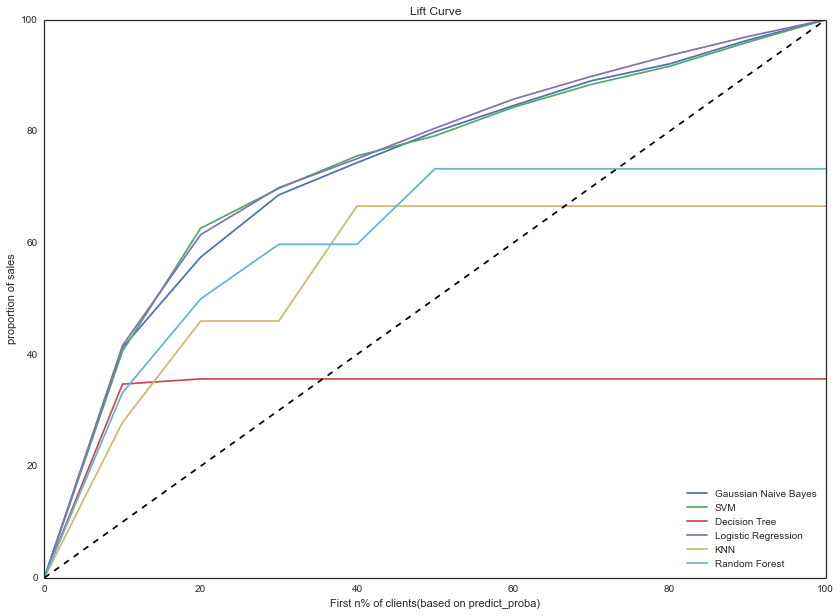

In [26]:
plt.figure(figsize=(14,10))
plt.plot(lift_comp['first n%'], lift_comp['sales_proportion_NB'], label='Gaussian Naive Bayes')
plt.plot(lift_comp['first n%'], lift_comp['sales_proportion_SVM'], label='SVM')
plt.plot(lift_comp['first n%'], lift_comp['sales_proportion_DT'], label='Decision Tree')
plt.plot(lift_comp['first n%'], lift_comp['sales_proportion_LR'], label='Logistic Regression')
plt.plot(lift_comp['first n%'], lift_comp['sales_proportion_KNN'], label='KNN')
plt.plot(lift_comp['first n%'], lift_comp['sales_proportion_RF'], label='Random Forest')
plt.plot(np.arange(0,101,10), np.arange(0,101,10), 'k--')
plt.xlabel('First n% of clients(based on predict_proba)')
plt.ylabel('proportion of sales')
plt.title('Lift Curve')
plt.legend(loc="lower right")


<b>Unsupervised Method - PCA (Biplot creation)</b>
<img src="https://raw.githubusercontent.com/rashmibanthia/coursework/master/CS109/project/Rplot.png"/>

******************************************* <b>R Code to create biplot</b>***************************************************************



bank = read.csv("bank-additional-full.csv",sep=";")<br>
par(mfrow=c(1,1))<br>
df = aggregate(cbind(pdays,previous,duration,cons.conf.idx,emp.var.rate,euribor3m)~job,bank,sum)<br>
row.names(df)=df[,1]<br>
drops <- c("job")<br>
df = df[,!(names(df) %in% drops)]<br>
pr.out = prcomp(df[-12,],scale=TRUE)<br>
biplot(pr.out,scale=0,cex=0.7,xlab="Principal Component 1", ylab="Principal Compoenent 2")<br>

***************************************************************************************************************

<b>Observation # 14: </b>

Above BiPlot is created in R. Here we see that euribor3m, pdays, duration are correlated variables. Similarly housemaid, entrepreneur, self-employed are also correlated. cons.conf.idx isn't correlated with euribor3m, pdays and duration.

The 41000(approx.) observations have been grouped by job type (eg: management, retired, student etc).  The numeric variables(emp.var.rate,cons.conf.idx,etc) are averages within the group. 

****************************************************************************************

<b>Final Summary:</b>
We used a Portuguese Banking Institution dataset for the 'Direct Marketing campaigns' with 41000 data points. Five classification models were tested (i.e., Logistics Regression, Decision Trees, Naïve Bayes, Support Vector Machines and Random Forest). We predicted the probability of customer accepting a term deposit for a customer not present in dataset. 

We compared the six classification models using two relevant criteria: ROC and Lift curve analysis. ROC and Lift curve are better predictors for evaluating marketing predictors as compare to accuracy score. Based on ROC curves, Lift Charts and Lift Curves for different models, <u>we observed Support Vector Machine (Area Under Curve = 0.74) and Logistics Regression obtained best results for this dataset</u>. 


<b> Challanges: </b> We tried few things not mentioned in our notebook - primarily because they weren't required or didn't work as well as we hoped. We tried - mapping our categorical variables to integers with out one hot encoding, Multinomial NB, Logistic Regression with dmatrices, Hierarchical clustering. We tried to get some external data, however the newer version of the dataset already had external factors included in it. Cross validation for SVM was avoided due to its computationally intensive requirements. Some things we could have added were - feature selection, better cross validation on all models. 
****************************************************************************************